# Lab 1

## Names: Ryogo, Will

## Day 1: Galaxy photometry

In [1]:
# Import some useful packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Run the next cell so you can access files in your Google Drive:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Read and clean data

In [5]:
def readdata(filename):
    '''Read in data from a *.csv file downloaded from NED.
    Inputs:
        filename (str): name of file to read in
    Outputs:
        newdf (pandas DataFrame): cleaned data (if there are multiple measurements at same frequency, take the brightest one)
    '''

    df = pd.read_csv(filename)
    newdf = df[df.duplicated('Frequency', keep=False)].groupby('Frequency')['Flux Density'].apply(list).reset_index()
    newdf['Flux Density'] = [np.nanmax(newdf['Flux Density'][i]) for i in range(len(newdf))]

    return newdf

# TODO: put in the filenames of your downloaded *.csv tables here!
galaxy1 = readdata('/content/drive/MyDrive/Academic/2025S/ASTR 352/Lab01/ngc2742.csv') # you will need to change the path here!
galaxy2 = readdata('/content/drive/MyDrive/Academic/2025S/ASTR 352/Lab01/ngc3239.csv')

### Plot SEDs

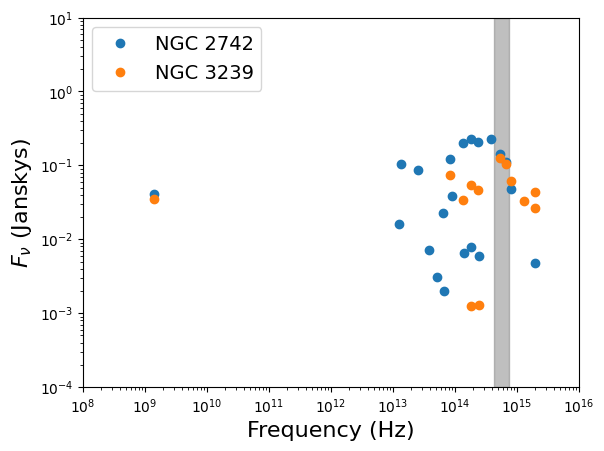

In [6]:
# TODO: modify the labels to list the actual galaxy names
plt.loglog(galaxy1['Frequency'], galaxy1['Flux Density'], ls='None', marker='o', label='NGC 2742')
plt.loglog(galaxy2['Frequency'], galaxy2['Flux Density'], ls='None', marker='o', label='NGC 3239')

# Mark the optical part of the spectrum with a gray band
c = 2.998e10  # cm/s
plt.axvspan(c/7e-5, c/4e-5, color='gray', alpha=0.5)

# TODO: put the correct units in these labels!
plt.xlabel('Frequency (Hz)', fontsize=16)
plt.ylabel(r'$F_{\nu}$ (Janskys)', fontsize=16)

# TODO: if needed, change these values to appropriate x- and y-limits
plt.xlim(1e8, 1e16)
plt.ylim(1e-4, 1e1)
plt.legend(loc='best', fontsize=14)

plt.show()

## Day 2: Galaxy spectra

In [7]:
# Import other useful packages
from astropy.io import fits
from astropy.modeling import models, fitting

In [12]:
def plot_spec(filename, galaxyname, xlim=(4000,9000)):
    '''Plot galaxy spectrum from SDSS FITS file.
    Inputs:
        filename (str): name of spectrum FITS file downloaded from SDSS
        galaxyname (str): name of galaxy

    Keywords:
        xlim (tuple): x-limits for plot
    '''

    # Open and plot data
    spec = fits.open(filename)[1].data
    plt.plot(10.**spec['loglam'], spec['flux'], 'k-')

    # Format plot
    plt.xlabel('Wavelength ($\AA$)', fontsize=16)
    plt.ylabel(r'$F_{\lambda}~(\mathrm{erg}/\mathrm{s}/\mathrm{cm}^{2}~/\AA)$', fontsize=16)
    plt.title(galaxyname+' spectrum', fontsize=12)
    plt.xlim(xlim)

    plt.show()

    return

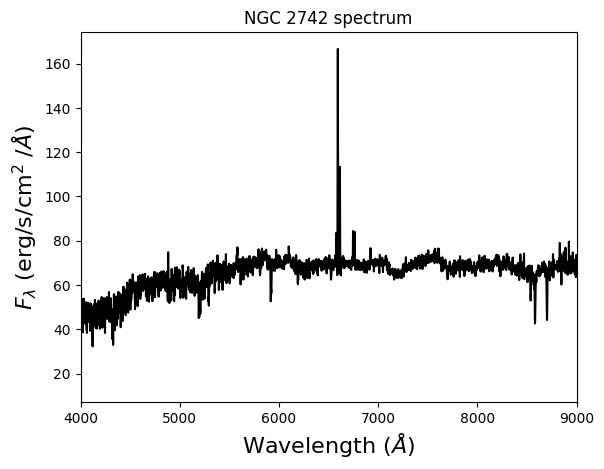

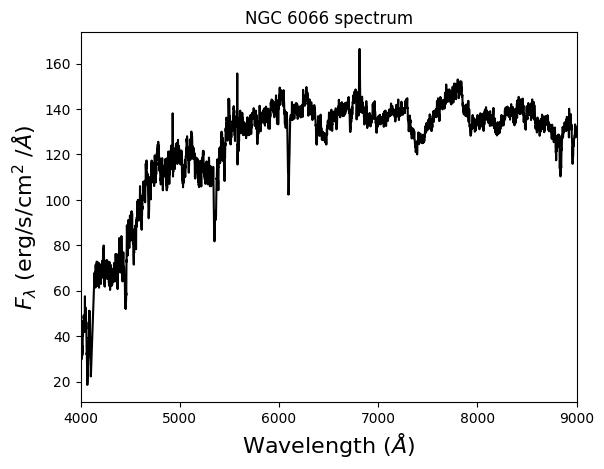

In [13]:
# TODO: Fill in the arguments for plot_spec() to make plots
plot_spec('/content/drive/MyDrive/Academic/2025S/ASTR 352/Lab01/ngc2742.fits', 'NGC 2742')
plot_spec('/content/drive/MyDrive/Academic/2025S/ASTR 352/Lab01/ngc6066.fits', 'NGC 6066')

In [49]:
def calc_z(filename, galaxyname, linename, lineinit, continuum, wvl0, xlim=(4000,7000)):
    '''Fit a line in a spectrum of a galaxy to compute redshift.
    Inputs:
        filename (str): name of spectrum FITS file downloaded from SDSS
        galaxyname (str): name of galaxy
        linename (str): name of line to fit
        lineinit (tuple): initial guesses for (amplitude, wavelength, stddev) of line
        continuum (float): initial guess for continuum level of spectrum
        wvl0 (float): rest-frame wavelength of line

    Keywords:
        xlim (tuple): x-limits for plot

    Outputs:
        z (float): redshift computed from line fit
    '''

    # Open and plot data
    spec = fits.open(filename)[1].data
    plt.plot(10.**spec['loglam'], spec['flux'], 'k-', label='Observed spectrum')

    #goodidx = np.where((10.**spec['loglam'] > 6500) & (10.**spec['loglam'] < 6700))[0]
    flux = spec['flux'] #[goodidx]
    loglam = spec['loglam'] #[goodidx]

    # Format plot
    plt.xlabel('Wavelength ($\AA$)', fontsize=16)
    plt.ylabel(r'$F_{\lambda}~(\mathrm{erg}/\mathrm{s}/\mathrm{cm}^{2}~/\AA)$', fontsize=16)
    plt.title(galaxyname+' spectrum', fontsize=14)
    plt.xlim(xlim)

    # Fit to line using a Gaussian + a constant value
    g_init = models.Gaussian1D(amplitude=lineinit[0], mean=lineinit[1], stddev=lineinit[2]) + models.Const1D(continuum)
    fit_g = fitting.LevMarLSQFitter()
    g = fit_g(g_init, 10.**loglam, flux)
    print(g.mean_0, g.amplitude_0, g.stddev_0)

    # Plot fit
    plt.plot(10.**loglam, g(10.**loglam), 'r-', label='Fit to '+linename+' line')

    plt.legend(loc='best', fontsize=12)
    plt.show()

    # TODO: compute redshift using the mean wavelength from your fit (g.mean_0) and the rest-frame wavelength (wvl0)
    z = (g.mean_0-wvl0)/wvl0
    print('Redshift: ', z)

    return z

Parameter('mean', value=6592.851837927978) Parameter('amplitude', value=108.30109812367293) Parameter('stddev', value=1.780890896682931, bounds=(1.1754943508222875e-38, None))


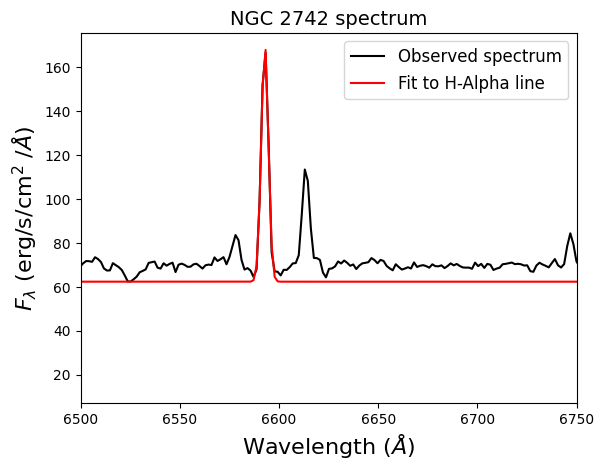

Redshift:  0.004579118353138512


0.004579118353138512

In [50]:
# For each of your two galaxies, fill in the arguments of calc_z() to calculate the redshift
calc_z('/content/drive/MyDrive/Academic/2025S/ASTR 352/Lab01/ngc2742.fits', 'NGC 2742', 'H-Alpha', lineinit=(175,6590,5), continuum=70, wvl0=6562.8, xlim=(6500,6750))

Parameter('mean', value=6096.98956644441) Parameter('amplitude', value=-13.50967036874399) Parameter('stddev', value=2.854660165211274, bounds=(1.1754943508222875e-38, None))


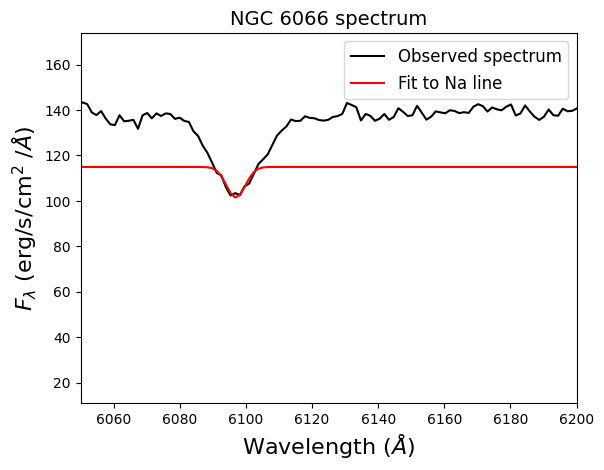

Redshift:  0.034106678614700146


0.034106678614700146

In [55]:
calc_z('/content/drive/MyDrive/Academic/2025S/ASTR 352/Lab01/ngc6066.fits', 'NGC 6066', 'Na', lineinit=(-30,6095,5), continuum=130, wvl0=5895.9, xlim=(6050,6200))